In [38]:
import datetime
import os
import tempfile

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import (Callback,  # type: ignore
                                        EarlyStopping, ReduceLROnPlateau,
                                        TensorBoard)
from tensorflow.keras.optimizers import Adam  # type: ignore
from tensorflow.keras.regularizers import l2  # type: ignore
from tensorflow.keras.utils import to_categorical  # type: ignore

#### Setting up for data training and testing

In [39]:
# actions to be trained
ACTIONS = [
    "selamat pagi"
]

#### Load and Augmented data

In [40]:
seq_path = os.path.join("d:/sds-ml-main/combined_sequences.npy")
lab_path = os.path.join("d:/sds-ml-main/combined_labels.npy")

In [41]:
# load the combined dataset
combined_sequences, combined_labels = np.load(seq_path), np.load(lab_path)

In [42]:
len(combined_sequences), len(combined_labels)

(600, 600)

**Adjusting the Augmentation Factor**

If you want to achieve a specific total number of sequences, you can adjust N<sub>augmented_per_original</sub>

- Desired N<sub>total</sub> = 1920
- Original N<sub>original</sub> = 480 (without augmentation)

Using the formula to find N<sub>augmented_per_original</sub> :
- 1920 = 480 + (480 × N<sub>augmented_per_original</sub>)

Subtract 480 from both sides :
- 1440 = 480 × N<sub>augmented_per_original</sub>

Divide both sides by 480 :
- N<sub>augmented_per_original</sub> = 3

In [43]:
# convert to numpy array
datas = np.array(combined_sequences)

# convert labels list to a one-hot encoded NumPy array
labels = to_categorical(combined_labels).astype(int)

In [44]:
# free up memory
import gc

# we do not need this variable again
# so we can just remove it to freed up some memory
del combined_sequences
del combined_labels

# force garbage collection
gc.collect()

134

In [45]:
# the length of the datas and labels should be the same
len(datas), len(labels)

(600, 600)

The shapes of the datasets depend on the total number of sequences and the sequence length. Here we processes 120 sequence of videos for each of the 4 actions, we have:

    Total sequences = 120 sequences/action × 4 actions = 480 sequences

Given a test_size of 0.2, 20% of the data (approximately 96 sequences) will be in the test set, and 80% (approximately 384 sequences) will be in the training set.

In [46]:
# splits the dataset into training and testing sets

# specifies that 20% of the data should be used as the test set,
# and the remaining 80% should be used as the training set.
X_train, X_test, y_train, y_test = train_test_split(datas, labels, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(480, 60, 225) (120, 60, 225) (480, 1) (120, 1)


In [47]:
def convert_to_tuple(arr):
    return tuple(arr.flatten())

# Convert arrays to a set of string representations for faster lookup
X_train_tuples = set(map(convert_to_tuple, X_train))
X_test_tuples = set(map(convert_to_tuple, X_test))

# Find the intersection
overlap = X_train_tuples.intersection(X_test_tuples)

# Assert that there are no overlaps
assert len(overlap) == 0, "Training and Test sets overlap!"

if len(overlap) == 0:
    print("No overlap found between training and test sets.")
else:
    print(f"Overlap found with {len(overlap)} samples.")


No overlap found between training and test sets.


In [48]:
# free up memory
import gc

# we do not need this variable again
# so we can just remove it to freed up some memory
del datas
del labels

# force garbage collection
gc.collect()

16

Wrong Output Example : `(384, 60, 225) (96, 60, 225) (384, 4, 2) (96, 4, 2)`

#### Modelling

In [49]:
def create_cnn_rnn_model(input_shape, num_classes):
    # Input layer
    inputs = tf.keras.Input(shape=input_shape, name="input_layer_1")

    # Batch normalization
    x = tf.keras.layers.BatchNormalization()(inputs)

    x = tf.keras.layers.Conv1D(
        16, kernel_size=2, activation="relu", kernel_regularizer=l2(0.01)
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Conv1D(
        32, kernel_size=2, activation="relu", kernel_regularizer=l2(0.01)
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Conv1D(
        64, kernel_size=3, activation="relu", kernel_regularizer=l2(0.01)
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)

    # Reshape layer
    x = tf.keras.layers.Reshape((6, 64))(x)

    # Bidirectional LSTM layers
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, activation="relu", return_sequences=True)
    )(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation="relu"))(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # dense layers
    x = tf.keras.layers.Dense(16, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    # output layer
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    # create model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model


# where 60 is the sequence length
# and 225 is the number of features (keypoints) per frame
input_shape = (60, 225)
num_classes = len(ACTIONS)

# create the model
model = create_cnn_rnn_model(input_shape, num_classes)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 60, 225)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 60, 225)        │           900 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 59, 16)         │         7,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 59, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 29, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 28, 32)         │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 14, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 12, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 6, 128)         │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,285 (715.96 KB)

 Trainable params: 182,355 (712.32 KB)

 Non-trainable params: 930 (3.63 KB)

##### Setting up callbacks for training

In [50]:
def create_log_dir(base_dir, use_time=False):
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    # check existing log directories
    existing_logs = [
        d
        for d in os.listdir(base_dir)
        if os.path.isdir(os.path.join(base_dir, d)) and d.startswith("train-")
    ]

    # determine the new log directory name
    if existing_logs and not use_time:
        latest_log = max(existing_logs)
        log_num = int(latest_log.split("-")[1]) + 1
        new_log_dir = os.path.join(base_dir, f"train-{str(log_num).zfill(3)}")

    if not existing_logs and not use_time:
        new_log_dir = os.path.join(base_dir, f"train-001")

    if use_time:
        new_log_dir = os.path.join(base_dir, f"train-{current_time}")

    # create the new log directory
    os.makedirs(new_log_dir)
    print(f"Created new log directory: {new_log_dir}")

    return new_log_dir


# callback for logging
log_dir = os.path.join(create_log_dir(os.path.join("../storage/logs"), True))

logging = TensorBoard(log_dir=log_dir)

Created new log directory: ../storage/logs\train-20240729-134433


##### Compiling Model

In [51]:
# set the optimizer with an initial learning rate
optimizer = Adam(learning_rate=1e-3, clipnorm=1.0)

# compile the model with the optimizer
model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

early_stopping = EarlyStopping(
    monitor="val_loss", patience=50, restore_best_weights=True, verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=5, min_lr=1e-5
)

##### Training Model

In [52]:
tf.keras.backend.clear_session()

# train the model with the callbacks
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler],
    batch_size=64,
)

Epoch 1/100


c:\Users\my\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
c:\Users\my\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\losses\losses.py:22: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 196ms/step - accuracy: 1.0000 - loss: 0.9275 - val_accuracy: 1.0000 - val_loss: 0.8155 - learning_rate: 0.0010
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.7837 - val_accuracy: 1.0000 - val_loss: 0.6862 - learning_rate: 0.0010
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.6588 - val_accuracy: 1.0000 - val_loss: 0.5753 - learning_rate: 0.0010
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 0.5520 - val_accuracy: 1.0000 - val_loss: 0.4812 - learning_rate: 0.0010
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.0000 - loss: 0.4616 - val_accuracy: 1.0000 - val_loss: 0.4021 - learning_rate: 0.0010
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 0.3857 - val_accuracy: 1.0000 - val_loss: 0.3360 - learning_rate: 0.0010
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 0.3223 - val_accuracy: 1.0000 - v

#### Confusion Evaluation

In [53]:
import itertools

import matplotlib.pyplot as plt  # type: ignore
from sklearn.metrics import accuracy_score, confusion_matrix  # type: ignore

In [54]:
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)

# compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

c:\Users\my\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
c:\Users\my\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [55]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print(f'Test accuracy: {test_acc}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.0807e-05
Test accuracy: 1.0


In [56]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [57]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=ACTIONS))

              precision    recall  f1-score   support

selamat pagi       1.00      1.00      1.00       120

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120



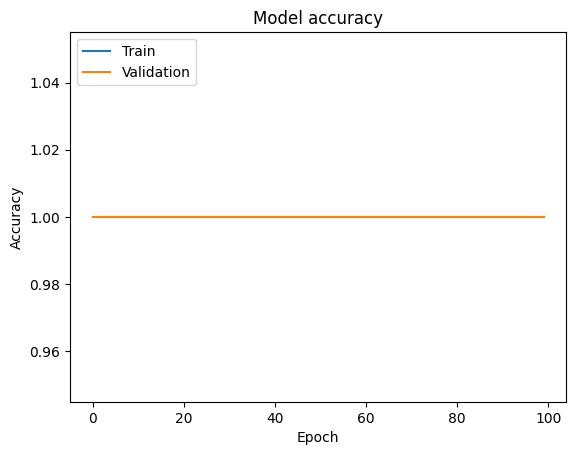

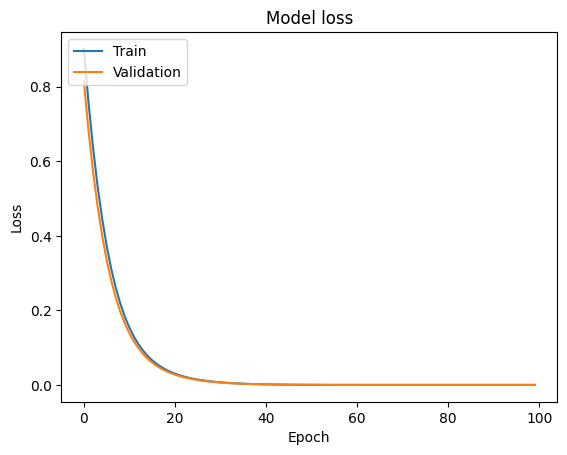

In [58]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Accuracy Score: 1.0


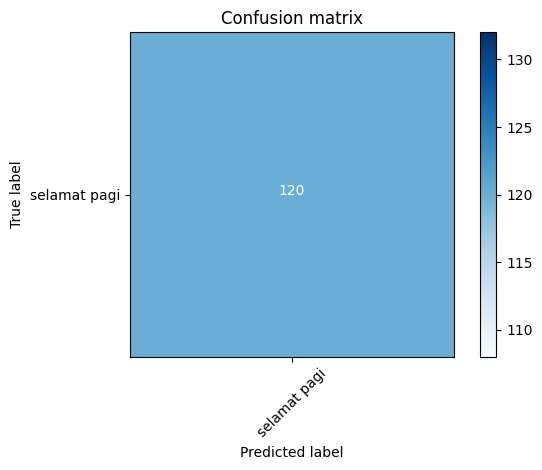

In [59]:
# plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(ACTIONS))
plt.xticks(tick_marks, ACTIONS, rotation=45)
plt.yticks(tick_marks, ACTIONS)

# add labels
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

# compute and print accuracy score
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy Score:", accuracy)

plt.show()

#### Saving the model

In [60]:
def get_next_filename(directory, base_name, extension):
    # list all files in the directory
    files = os.listdir(directory)

    # filter files that start with the base_name and end with the extension
    versions = [f for f in files if f.startswith(base_name) and f.endswith(extension)]

    # if the models directory is empty, then use the
    # default start version (001)
    if not versions and base_name == "signdeafspeech_sds_v_":
        return f"{base_name}001.{extension}"

    # if the given basename is different than the actual basename
    # then save the model with given name
    if not base_name == "signdeafspeech_sds_v_":
        return f"{base_name}.{extension}"

    # extract version numbers from filenames
    versions = [file.split("_")[-1] for file in versions]

    # convert version numbers to tuples of integers for comparison
    versions_int = [int(v.split(".")[0]) for v in versions]

    next_version = max(versions_int) + 1

    # format the next number with leading zeros to maintain the same length
    next_filename = f"{base_name}{next_version:03d}.{extension}"

    return next_filename


def save_as_tflite(_model, model_path):
    with tempfile.TemporaryDirectory() as temp_dir:
        # export the model to the temporary directory
        export_path = os.path.join(temp_dir, "_tf_temp")

        _model.export(export_path)

        converter = tf.lite.TFLiteConverter.from_saved_model(export_path)
        # enable resource variables and selective ops to handle the conversion issues
        converter.experimental_enable_resource_variables = True
        converter.target_spec.supported_ops = [
            tf.lite.OpsSet.TFLITE_BUILTINS,
            tf.lite.OpsSet.SELECT_TF_OPS,
        ]
        converter._experimental_lower_tensor_list_ops = False

        tflite_model = converter.convert()

        with open(model_path, "wb") as f:
            f.write(tflite_model)

        f.close()


def save_as_keras(_model, model_path):
    _model.save(model_path)


def save_model(_model, extension="keras", base_name="signdeafspeech_sds_v_"):
    model_dir = os.path.join("..", "storage", "models", extension)

    next_filename = get_next_filename(model_dir, base_name, extension)
    model_path = os.path.join(model_dir, next_filename)

    if extension == "tflite":
        save_as_tflite(_model, model_path)
        print(f"Saved as tflite at {model_path}")

    elif extension == "keras":
        save_as_keras(_model, model_path)
        print(f"Saved as keras at {model_path}")

In [61]:
def convert_to_tuple(arr):
    return tuple(arr.flatten())

# Convert arrays to a set of string representations for faster lookup
X_train_tuples = set(map(convert_to_tuple, X_train))
X_test_tuples = set(map(convert_to_tuple, X_test))

# Find the intersection
overlap = X_train_tuples.intersection(X_test_tuples)

# Assert that there are no overlaps
assert len(overlap) == 0, "Training and Test sets overlap!"

if len(overlap) == 0:
    print("No overlap found between training and test sets.")
else:
    print(f"Overlap found with {len(overlap)} samples.")


No overlap found between training and test sets.


In [62]:
save_model(model)

Saved as keras at ..\storage\models\keras\signdeafspeech_sds_v_005.keras


In [63]:
save_model(model, extension="tflite")

c:\Users\my\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


INFO:tensorflow:Assets written to: C:\Users\my\AppData\Local\Temp\tmplyo9dwli\_tf_temp\assets


INFO:tensorflow:Assets written to: C:\Users\my\AppData\Local\Temp\tmplyo9dwli\_tf_temp\assets


Saved artifact at 'C:\Users\my\AppData\Local\Temp\tmplyo9dwli\_tf_temp'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 60, 225), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1778120268256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1779603183392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1778120267728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1778120268432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1778154032464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1778153999520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1778119138112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1778119137760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1778119164320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1778119166960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  17

In [37]:
# free up memory
import gc

# we do not need this variable again
# so we can just remove it to freed up some memory
del X_train
del X_test
del y_train
del y_test

# force garbage collection
gc.collect()

47590